# 2024 CITS4012 Project

# ReadMme

# 1. Dataset Processing

## Importing Libraries

In [1]:
import re
import json
import nltk
import time
import math
import spacy
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
import matplotlib.pyplot as plt

## Loading Datasets

In [2]:
# Load the training data
# with open('/content/drive/MyDrive/data/train.json', 'r') as file:
with open('train.json', 'r') as file:
    data = json.load(file)
    train_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the test data
# with open('/content/drive/MyDrive/data/test.json', 'r') as file:
with open('test.json', 'r') as file:
    data = json.load(file)
    test_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the validation data
# with open('/content/drive/MyDrive/data/val.json', 'r') as file:
with open('val.json', 'r') as file:
    data = json.load(file)
    val_data = pd.DataFrame(data['data'], columns=data['columns'])

# Get the x and y lists for training data and test data
training_x = train_data['sentence'].tolist() + val_data['sentence'].tolist()
training_a = train_data['aspect'].tolist() + val_data['aspect'].tolist()
training_y = train_data['polarity'].tolist() + val_data['polarity'].tolist()
test_x = test_data['sentence'].tolist()
test_a = test_data['aspect'].tolist()
test_y = test_data['polarity'].tolist()

## Dataset Analysis

In [3]:
# Size of datasets
print("Training data size :", len(training_x))
print("Test data size     :", len(test_x))

# Aspect Distribution
aspect_distribution = train_data['aspect'].value_counts()
print("\nAspect Distribution:")
print(aspect_distribution.to_string(header=False))

# Polarity Distribution
polarity_distribution = train_data['polarity'].value_counts()
print("\nPolarity Distribution:")
print(polarity_distribution.to_string(header=False))

# Aspect-Sentiment Pair Distribution
aspect_polarity_pair = [(a, p) for a, p in zip(train_data['aspect'], train_data['polarity'])]
aspect_polarity_freq = pd.Series(aspect_polarity_pair).value_counts()
print("\nAspect-Sentiment Pair Distribution:")
print(aspect_polarity_freq.to_string(header=False))

Training data size : 7978
Test data size     : 901

Aspect Distribution:
food             2307
staff            1383
miscellaneous     954
place             694
service           631
menu              475
ambience          324
price             322

Polarity Distribution:
neutral     3077
negative    2084
positive    1929

Aspect-Sentiment Pair Distribution:
(food, neutral)              1298
(staff, negative)             922
(food, positive)              754
(miscellaneous, neutral)      531
(place, neutral)              430
(menu, neutral)               372
(staff, positive)             332
(service, negative)           329
(food, negative)              255
(miscellaneous, positive)     227
(miscellaneous, negative)     196
(ambience, positive)          181
(service, positive)           174
(place, negative)             139
(price, neutral)              136
(staff, neutral)              129
(service, neutral)            128
(place, positive)             125
(price, negative)          

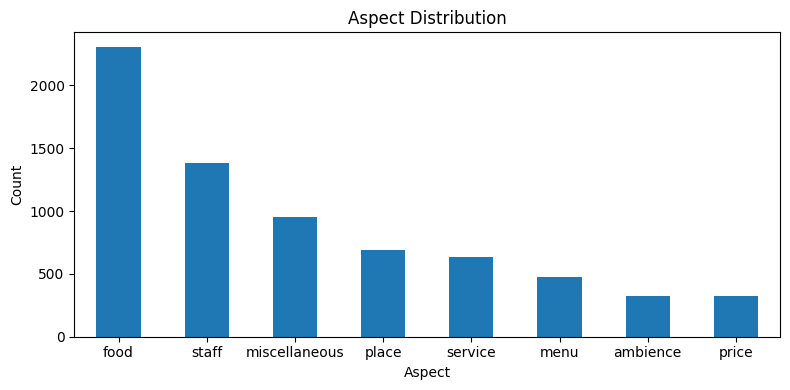

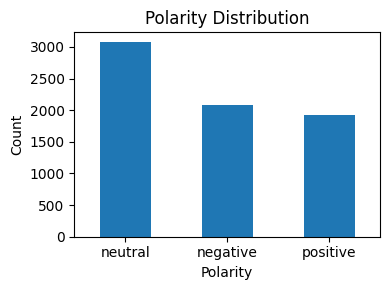

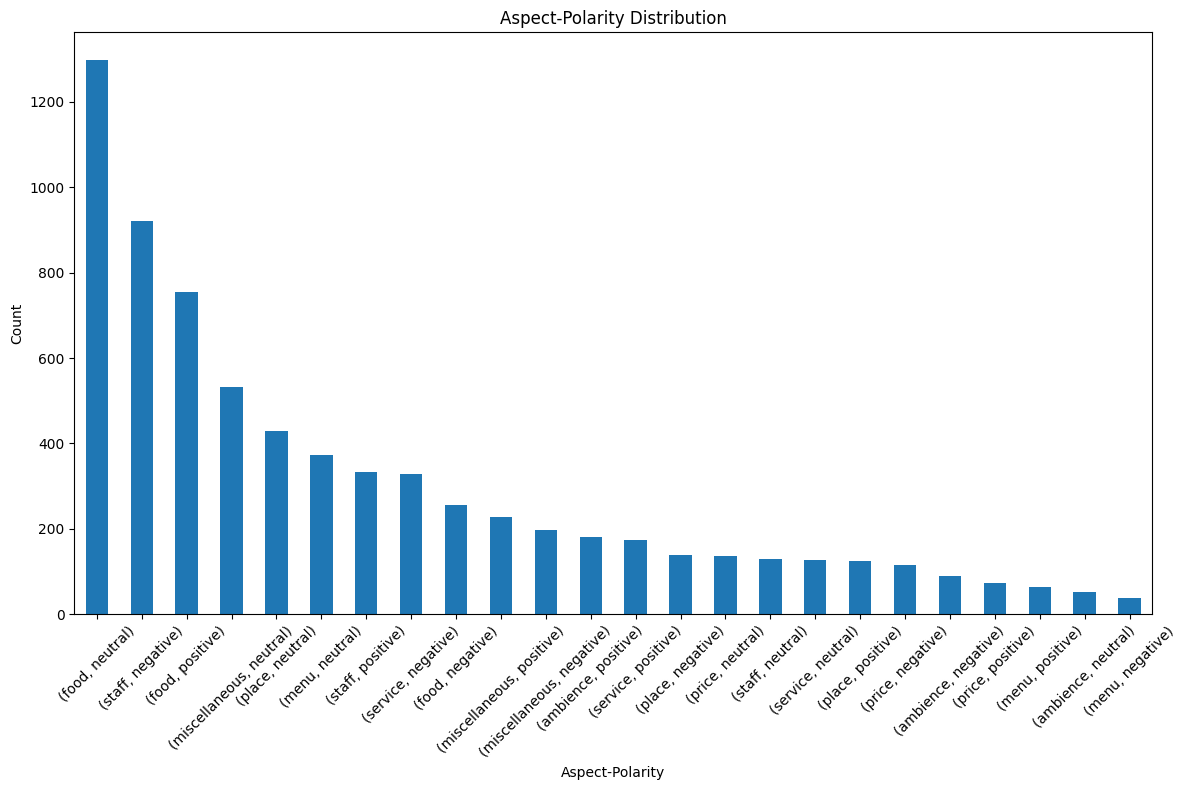

In [4]:
# Plot Aspect Distribution
plt.figure(figsize=(8, 4))
aspect_distribution.plot(kind='bar')
plt.title('Aspect Distribution')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot Polarity Distribution
plt.figure(figsize=(4, 3))
polarity_distribution.plot(kind='bar')
plt.title('Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot Aspect-Polarity Distribution
plt.figure(figsize=(12, 8))
aspect_polarity_freq.plot(kind='bar')
plt.title('Aspect-Polarity Distribution')
plt.xlabel('Aspect-Polarity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data Preprocessing

In [5]:
! python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 660.6 kB/s eta 0:00:20
     ---------------------------------------- 0.2/12.8 MB 1.8 MB/s eta 0:00:07
      --------------------------------------- 0.3/12.8 MB 2.4 MB/s eta 0:00:06
     - -------------------------------------- 0.5/12.8 MB 2.7 MB/s eta 0:00:05
     - -------------------------------------- 0.6/12.8 MB 2.6 MB/s eta 0:00:05
     -- ------------------------------------- 0.8/12.8 MB 2.8 MB/s eta 0:00:05
     -- ------------------------------------- 0.9/12.8 MB 2.9 MB/s eta 0:00:05
     --- ------------------------------------ 1.1/12.8 MB 3.0 MB/s eta 0:00:04
     --- ------------------------------------ 1.2/12.8 MB 3.0 MB/s eta 0:00:04
     ---- ----------------------------------- 1.4/12.8 MB 3.1 MB/s eta 0:00:04
     ---- ----------------------------------- 1.5/12.8 MB 3.1 MB/s eta 0:00:04
     ----- ---------------------------------- 1.7/12.8 MB 

In [6]:
# Punctuation Removal
def remove_punctuation_re(x):
    x = re.sub(r'[^\w\s]', '', x)
    return x

nltk.download('punkt')

# Stopwords Removal
nlp = spacy.load("en_core_web_sm")

def remove_stopwords(x):
    doc = nlp(x)
    x = [word.text for word in doc if not word.is_stop]
    return x

# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem(x):
    x = [stemmer.stem(word) for word in x]
    return x

# Lemmatisation
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(x):
    x = [lemmatizer.lemmatize(word) for word in x]
    return x

# English Contractions Dictionary
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Emoticons
EMOTICONS = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
      |
      <3                         # heart
    )"""

EMOTICON_RE = re.compile(EMOTICONS, re.VERBOSE | re.I | re.UNICODE)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Peter\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Peter\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Function to preprocess the data
def preprocess_data(sentence_list):
    output_list = []
    for sentence in sentence_list:
        emoticons = EMOTICON_RE.findall(sentence)       # Extract emoticons
        sentence = EMOTICON_RE.sub('', sentence)        # Remove emoticons
        sentence = sentence.lower()                     # Case folding
        for word, new_word in contraction_dict.items(): # Deal with contractions
            sentence = sentence.replace(word, new_word)
        sentence = remove_punctuation_re(sentence)      # Remove punctuation
        tokens = remove_stopwords(sentence)             # Remove stopwords / Tokenise
        # tokens = stem(tokens)                           # Stemming
        tokens = lemmatize(tokens)                      # Lemmatisation
        tokens.extend(emoticons)                        # Add emoticons back
        output_list.append(tokens)
    return output_list

# Preprocess the data and get the tokenised sentence lists
train_x_token = preprocess_data(training_x)
test_x_token = preprocess_data(test_x)

## Create Word Vocabulary

In [8]:
# Get longest sentence length
longest_sentence = max(train_x_token, key=len)
MAX_LENGTH = len(longest_sentence)

# Word vocabulary to index dictionary {word: index}
word_to_idx = {'<PAD>': 0, '<SEP>': 1}
review = train_x_token + test_x_token
aspect = [list(set(training_a))]
polarity = [list(set(training_y))]

# Vocabulary includes words from reviews and aspects
for sentence in aspect+review:
    for word in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
word_list = list(word_to_idx.keys())
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)

# Polarity vocabulary to index dictionary {polarity: index}
polarity_to_idx = {p: i for i, p in enumerate(polarity[0])}
idx_to_polarity = {idx: pol for pol, idx in polarity_to_idx.items()}

## Convert Words to Index form

In [9]:
def list_to_index(token_list, word_to_idx):
    idx_list = []
    for tokens in token_list:
        idx_list.append([word_to_idx[token] for token in tokens])
    return idx_list

def string_to_index(aspect_list, word_to_idx):
    idx_list = []
    for aspect in aspect_list:
        idx_list.append(word_to_idx[aspect])
    return idx_list

# Append aspect to the end of the sentence
def combine_sentence_aspect(sentence, aspect, has_sep):
    if has_sep:
        sep_idx = word_to_idx['<SEP>']
        combined_idx = sentence + [sep_idx] + [aspect]
    else:
        combined_idx = sentence + [aspect]
    return combined_idx

# Append aspect after every word
def combine_repeat_aspect(sentence, aspect, has_sep):
    output = []
    for word in sentence:
        if has_sep:
            sep_idx = word_to_idx['<SEP>']
            output = output + [word] + [sep_idx] + [aspect]
        else:
            output = output + [word] + [aspect]
    return output

# Token index lists for training data
train_x_idx = list_to_index(train_x_token, word_to_idx)
train_a_idx = string_to_index(training_a, word_to_idx)
train_y_idx = string_to_index(training_y, polarity_to_idx)

# Max length of the sentence after appending aspect
MAX_COMBINED_LENGTH = MAX_LENGTH + 1
MAX_REP_LENGTH = MAX_LENGTH*2
MAX_REPSEP_LENGTH = MAX_LENGTH*3

## Pretrained Word Embeddings from Glove

In [10]:
glove_model = api.load("glove-twitter-100")
# glove_weights = torch.FloatTensor(glove_model.vectors)

In [11]:
# Get Weights for the Embedding Layer (GloVe)
embedding_size = 100

glove_weights = np.zeros((vocab_size, embedding_size))
for i, word in enumerate(word_to_idx.keys()):
    try:
        # If word in glove, get the weights
        glove_weights[i] = glove_model[word]
    except:
        # If word not in glove, initialise with random weights
        glove_weights[i] = np.random.uniform(low=-0.1, high=0.1, size=embedding_size)

# 2. Model Implementation

## Model Variants

In [12]:
# Different aspect integration
NO_ASPECT       = 'no aspect'
ASPECT_EMBED    = 'aspect embedding'
WITH_SEP        = 'with separator'
NO_SEP          = 'no separator'
ASPECT_REP_SEP  = 'aspect repeat with separator'
ASPECT_REP      = 'aspect repeat'

# Different attention mechanisms
ATTN_NONE       = 'no_attention'
ATTN_DOT        = 'dot_product'
ATTN_SCALE_DOT  = 'scaled_dot_product'
ATTN_COSINE     = 'cosine_similarity'

In [13]:
# Model
class Model(nn.Module):
    def __init__(self, hidden_size, output_size, embedding, integration, attention='dot_product', num_layers=1):
        super(Model, self).__init__()
        self.integration_type = integration
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        self.linear_attention = nn.Linear(self.hidden_size*2, self.output_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def attention(self, hidden, encoder_hiddens):
        if self.attention_type == ATTN_DOT:            # Dot product attention
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)), dim=-1)
        elif self.attention_type == ATTN_SCALE_DOT:   # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)) * scale, dim=-1)
        elif self.attention_type == ATTN_COSINE:    # Cosine similarity attention
            query = hidden / torch.norm(hidden, dim=-1)
            keys = encoder_hiddens / torch.norm(encoder_hiddens.T, dim=-1)
            norm_product = torch.bmm(query, keys.T.unsqueeze(0))
            attn_weights = F.softmax(norm_product, dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
        concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        output = F.log_softmax(self.linear_attention(concat_output), dim=1)
        return output
            
    def forward(self, input, hidden, cell, encoder_hiddens, aspect, is_last):
        word_embedding = self.embedding(input).view(1, 1, -1)
        if self.integration_type in [WITH_SEP, NO_SEP, ASPECT_REP_SEP, ASPECT_REP, NO_ASPECT]:
            output, (hidden, cell) = self.lstm(word_embedding, (hidden, cell))
        elif self.integration_type == ASPECT_EMBED:
            aspect_embedding = self.embedding(aspect).view(1, 1, -1)
            embedded = torch.cat((aspect_embedding, word_embedding), 0)
            output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        
        if is_last: # Attention Mechanism and generate output
            if self.attention_type == ATTN_NONE:
                output = F.log_softmax(self.linear(output[0]), dim=1)
            else:
                output = self.attention(hidden, encoder_hiddens)
        return output, (hidden, cell)

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [14]:
# Function to get time elapse for training
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Function to feep input tensor into encoder
def feed_encoder(encoder, input_tensor, aspect_tensor, max_length):
    hiddens = torch.zeros(max_length, encoder.hidden_size) # For attention mechanism
    hidden = encoder.init_hidden() # Hidden state for encoder
    cell = encoder.init_hidden()   # Cell state for encoder
    for i in range(input_tensor.size(0)):
        is_last = (i==input_tensor.size(0)-1)
        if is_last:
            y_output, (_, _) = encoder(input_tensor[i], hidden, cell, hiddens, aspect_tensor, is_last=is_last)
        else:
            _, (hidden, cell) = encoder(input_tensor[i], hidden, cell, hiddens, aspect_tensor, is_last=is_last)
            hiddens[i] = hidden[0, 0]    
    return y_output

# Function to prepare input tensors for different integration types
def prepare_input_tensors(sent_idx, asp_idx, combine_function):
    combined = combine_function(sent_idx, asp_idx, has_sep=False)
    index = [[idx] for idx in combined]
    tensor = torch.LongTensor(index)
    
    combined_sep = combine_function(sent_idx, asp_idx, has_sep=True)
    sep_index = [[idx] for idx in combined_sep]
    sep_tensor = torch.LongTensor(sep_index)
    return tensor, sep_tensor

# Function to prepare data for training
def prepare_data(random_idx):
    # Input data
    x_index = [[idx] for idx in train_x_idx[random_idx]]
    x_tensor = torch.LongTensor(x_index)
    
    a_index = train_a_idx[random_idx]
    a_tensor = torch.LongTensor([a_index])
    
    x_temp = train_x_idx[random_idx]
    xa_tensor, xa_sep_tensor = prepare_input_tensors(x_temp, a_index, combine_sentence_aspect)
    xar_tensor, xar_sep_tensor = prepare_input_tensors(x_temp, a_index, combine_repeat_aspect)
    
    # Target data
    y_index = train_y_idx[random_idx]
    y_tensor = torch.LongTensor([y_index])
    
    return x_tensor, a_tensor, xa_tensor, xa_sep_tensor, xar_tensor, xar_sep_tensor, y_tensor

In [15]:
# Function to train model
def train(embedding, attention_type, integration_type,
          num_epochs=10000, 
          print_interval=500, 
          plot_interval=200, 
          learning_rate=0.001, 
          hidden_size=100):
    
    model = Model(hidden_size, 3, embedding, integration_type, attention_type, num_layers=1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    plot_all_losses, plot_avg_losses, print_loss_total, plot_loss_total = [], [], 0, 0
    start = time.time()

    for epoch in range(1, num_epochs+1):
        random_idx = random.choice(range(len(train_data)))
        x_tensor, a_tensor, xa_tensor, xa_sep_tensor, xar_tensor, xar_sep_tensor, y_tensor = prepare_data(random_idx)

        loss = 0
        model.train()
        optimizer.zero_grad()
        
        # Feed the input tensor into the encoder
        if integration_type == NO_ASPECT:
            y_output = feed_encoder(model, x_tensor, a_tensor, MAX_LENGTH)
        elif integration_type == WITH_SEP:
            y_output = feed_encoder(model, xa_sep_tensor, a_tensor, MAX_COMBINED_LENGTH+1)
        elif integration_type == ASPECT_EMBED:
            y_output = feed_encoder(model, x_tensor, a_tensor, MAX_LENGTH)
        elif integration_type == NO_SEP:
            y_output = feed_encoder(model, xa_tensor, a_tensor, MAX_COMBINED_LENGTH)
        elif integration_type == ASPECT_REP_SEP:
            y_output = feed_encoder(model, xar_sep_tensor, a_tensor, MAX_REPSEP_LENGTH)
        elif integration_type == ASPECT_REP:
            y_output = feed_encoder(model, xar_tensor, a_tensor, MAX_REP_LENGTH)
        
        loss += criterion(y_output, y_tensor)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        print_loss_total += loss.item()
        plot_loss_total += loss.item()
        plot_all_losses.append(loss.item())
        
        if epoch % print_interval == 0:
            print_avg_loss = print_loss_total / print_interval
            print_time = timeSince(start, epoch / num_epochs)
            print(f'{print_time} Epoch [{epoch}/{num_epochs}] Loss: {print_avg_loss:.4f}')
            print_loss_total = 0
            
        if epoch % plot_interval == 0:
            plot_avg_loss = plot_loss_total / plot_interval
            plot_avg_losses.append(plot_avg_loss)
            plot_loss_total = 0
            
    return model, plot_all_losses, plot_avg_losses

# Function to plot loss graphs over epochs
def plot_graphs(num_epochs, interval, plot_all_losses, plot_avg_losses):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), plot_all_losses)
    plt.title('All Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1, interval), plot_avg_losses)
    plt.title('Average Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

## Aspect Repeat no Separator

In [16]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 100

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))

# Set different attention and integration types
attention_type   = ATTN_NONE
integration_type = ASPECT_REP

# Train the model
model5, plot_all_losses0, plot_avg_losses0 = train(embedding, attention_type, integration_type)

0m 9s (- 3m 6s) Epoch [500/10000] Loss: 0.9707
0m 19s (- 2m 56s) Epoch [1000/10000] Loss: 0.9176
0m 29s (- 2m 45s) Epoch [1500/10000] Loss: 0.9296
0m 39s (- 2m 36s) Epoch [2000/10000] Loss: 0.9166
0m 49s (- 2m 27s) Epoch [2500/10000] Loss: 0.9210
0m 59s (- 2m 17s) Epoch [3000/10000] Loss: 0.9035
1m 9s (- 2m 8s) Epoch [3500/10000] Loss: 0.8775
1m 19s (- 1m 58s) Epoch [4000/10000] Loss: 0.8407
1m 29s (- 1m 49s) Epoch [4500/10000] Loss: 0.8691
1m 39s (- 1m 39s) Epoch [5000/10000] Loss: 0.8533
1m 49s (- 1m 29s) Epoch [5500/10000] Loss: 0.7619
1m 59s (- 1m 19s) Epoch [6000/10000] Loss: 0.7842
2m 9s (- 1m 9s) Epoch [6500/10000] Loss: 0.8263
2m 19s (- 0m 59s) Epoch [7000/10000] Loss: 0.7756
2m 29s (- 0m 49s) Epoch [7500/10000] Loss: 0.7414
2m 39s (- 0m 39s) Epoch [8000/10000] Loss: 0.7453
2m 49s (- 0m 29s) Epoch [8500/10000] Loss: 0.7995
3m 0s (- 0m 20s) Epoch [9000/10000] Loss: 0.7981
3m 11s (- 0m 10s) Epoch [9500/10000] Loss: 0.6915
3m 21s (- 0m 0s) Epoch [10000/10000] Loss: 0.7320


## Aspect Repeat with Separator

In [17]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 100

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))

# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = ASPECT_REP_SEP

# Train the model
model0, plot_all_losses1, plot_avg_losses1 = train(embedding, attention_type, integration_type)

0m 14s (- 4m 26s) Epoch [500/10000] Loss: 0.9884
0m 28s (- 4m 15s) Epoch [1000/10000] Loss: 0.9177
0m 43s (- 4m 3s) Epoch [1500/10000] Loss: 0.9073
0m 57s (- 3m 49s) Epoch [2000/10000] Loss: 0.9282
1m 11s (- 3m 35s) Epoch [2500/10000] Loss: 0.9081
1m 25s (- 3m 20s) Epoch [3000/10000] Loss: 0.8777
1m 40s (- 3m 6s) Epoch [3500/10000] Loss: 0.9103
1m 54s (- 2m 52s) Epoch [4000/10000] Loss: 0.8067
2m 9s (- 2m 37s) Epoch [4500/10000] Loss: 0.8346
2m 23s (- 2m 23s) Epoch [5000/10000] Loss: 0.8133
2m 38s (- 2m 9s) Epoch [5500/10000] Loss: 0.7672
2m 52s (- 1m 54s) Epoch [6000/10000] Loss: 0.8572
3m 6s (- 1m 40s) Epoch [6500/10000] Loss: 0.8469
3m 21s (- 1m 26s) Epoch [7000/10000] Loss: 0.8167
3m 36s (- 1m 12s) Epoch [7500/10000] Loss: 0.7933
3m 50s (- 0m 57s) Epoch [8000/10000] Loss: 0.8125
4m 5s (- 0m 43s) Epoch [8500/10000] Loss: 0.7549
4m 20s (- 0m 28s) Epoch [9000/10000] Loss: 0.7884
4m 34s (- 0m 14s) Epoch [9500/10000] Loss: 0.7582
4m 48s (- 0m 0s) Epoch [10000/10000] Loss: 0.7432


## Aspect Embedding

In [18]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 100

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))

# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = ASPECT_EMBED

# Train the model
model1, plot_all_losses2, plot_avg_losses2 = train(embedding, attention_type, integration_type)

0m 7s (- 2m 16s) Epoch [500/10000] Loss: 1.0190
0m 14s (- 2m 10s) Epoch [1000/10000] Loss: 0.9562
0m 21s (- 2m 1s) Epoch [1500/10000] Loss: 0.8976
0m 28s (- 1m 54s) Epoch [2000/10000] Loss: 0.8674
0m 35s (- 1m 47s) Epoch [2500/10000] Loss: 0.8602
0m 43s (- 1m 41s) Epoch [3000/10000] Loss: 0.8488
0m 50s (- 1m 33s) Epoch [3500/10000] Loss: 0.8438
0m 57s (- 1m 26s) Epoch [4000/10000] Loss: 0.8359
1m 5s (- 1m 19s) Epoch [4500/10000] Loss: 0.8314
1m 12s (- 1m 12s) Epoch [5000/10000] Loss: 0.8052
1m 19s (- 1m 5s) Epoch [5500/10000] Loss: 0.8125
1m 26s (- 0m 57s) Epoch [6000/10000] Loss: 0.7916
1m 33s (- 0m 50s) Epoch [6500/10000] Loss: 0.7644
1m 40s (- 0m 43s) Epoch [7000/10000] Loss: 0.7901
1m 47s (- 0m 35s) Epoch [7500/10000] Loss: 0.7606
1m 54s (- 0m 28s) Epoch [8000/10000] Loss: 0.7306
2m 2s (- 0m 21s) Epoch [8500/10000] Loss: 0.7131
2m 8s (- 0m 14s) Epoch [9000/10000] Loss: 0.6836
2m 16s (- 0m 7s) Epoch [9500/10000] Loss: 0.6765
2m 23s (- 0m 0s) Epoch [10000/10000] Loss: 0.7096


## With Separator

In [19]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 100

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))

# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = WITH_SEP

# Train the model
model2, plot_all_losses3, plot_avg_losses3 = train(embedding, attention_type, integration_type)

0m 6s (- 2m 8s) Epoch [500/10000] Loss: 0.9714
0m 13s (- 2m 1s) Epoch [1000/10000] Loss: 0.8835
0m 20s (- 1m 54s) Epoch [1500/10000] Loss: 0.8620
0m 26s (- 1m 47s) Epoch [2000/10000] Loss: 0.8605
0m 33s (- 1m 40s) Epoch [2500/10000] Loss: 0.8369
0m 40s (- 1m 33s) Epoch [3000/10000] Loss: 0.8678
0m 46s (- 1m 27s) Epoch [3500/10000] Loss: 0.7842
0m 53s (- 1m 20s) Epoch [4000/10000] Loss: 0.7713
1m 0s (- 1m 13s) Epoch [4500/10000] Loss: 0.7653
1m 6s (- 1m 6s) Epoch [5000/10000] Loss: 0.7705
1m 13s (- 1m 0s) Epoch [5500/10000] Loss: 0.7474
1m 20s (- 0m 53s) Epoch [6000/10000] Loss: 0.7296
1m 27s (- 0m 46s) Epoch [6500/10000] Loss: 0.6542
1m 34s (- 0m 40s) Epoch [7000/10000] Loss: 0.7273
1m 41s (- 0m 33s) Epoch [7500/10000] Loss: 0.6638
1m 48s (- 0m 27s) Epoch [8000/10000] Loss: 0.6723
1m 55s (- 0m 20s) Epoch [8500/10000] Loss: 0.6075
2m 2s (- 0m 13s) Epoch [9000/10000] Loss: 0.6496
2m 9s (- 0m 6s) Epoch [9500/10000] Loss: 0.6398
2m 16s (- 0m 0s) Epoch [10000/10000] Loss: 0.5751


## No Aspect

In [20]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 100

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))

# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = NO_ASPECT

# Train the model
model3, plot_all_losses4, plot_avg_losses4 = train(embedding, attention_type, integration_type)

0m 6s (- 1m 59s) Epoch [500/10000] Loss: 1.0683
0m 12s (- 1m 52s) Epoch [1000/10000] Loss: 1.0334
0m 18s (- 1m 45s) Epoch [1500/10000] Loss: 1.0111
0m 24s (- 1m 39s) Epoch [2000/10000] Loss: 1.0099
0m 31s (- 1m 33s) Epoch [2500/10000] Loss: 0.9792
0m 36s (- 1m 26s) Epoch [3000/10000] Loss: 1.0124
0m 42s (- 1m 19s) Epoch [3500/10000] Loss: 0.9708
0m 48s (- 1m 13s) Epoch [4000/10000] Loss: 1.0110
0m 54s (- 1m 7s) Epoch [4500/10000] Loss: 0.9791
1m 0s (- 1m 0s) Epoch [5000/10000] Loss: 0.9543
1m 6s (- 0m 54s) Epoch [5500/10000] Loss: 0.9521
1m 12s (- 0m 48s) Epoch [6000/10000] Loss: 0.9236
1m 18s (- 0m 42s) Epoch [6500/10000] Loss: 0.9390
1m 24s (- 0m 36s) Epoch [7000/10000] Loss: 0.9206
1m 30s (- 0m 30s) Epoch [7500/10000] Loss: 0.9212
1m 36s (- 0m 24s) Epoch [8000/10000] Loss: 0.8878
1m 42s (- 0m 18s) Epoch [8500/10000] Loss: 0.9216
1m 48s (- 0m 12s) Epoch [9000/10000] Loss: 0.9043
1m 55s (- 0m 6s) Epoch [9500/10000] Loss: 0.9399
2m 2s (- 0m 0s) Epoch [10000/10000] Loss: 0.9011


## No Separator

In [21]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 100

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))

# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = NO_SEP

# Train the model
model4, plot_all_losses5, plot_avg_losses5 = train(embedding, attention_type, integration_type)

0m 6s (- 2m 12s) Epoch [500/10000] Loss: 0.9310
0m 13s (- 2m 1s) Epoch [1000/10000] Loss: 0.8787
0m 20s (- 1m 54s) Epoch [1500/10000] Loss: 0.7983
0m 27s (- 1m 48s) Epoch [2000/10000] Loss: 0.8060
0m 34s (- 1m 42s) Epoch [2500/10000] Loss: 0.8411
0m 40s (- 1m 34s) Epoch [3000/10000] Loss: 0.7881
0m 47s (- 1m 27s) Epoch [3500/10000] Loss: 0.8032
0m 53s (- 1m 20s) Epoch [4000/10000] Loss: 0.7230
0m 59s (- 1m 13s) Epoch [4500/10000] Loss: 0.7930
1m 6s (- 1m 6s) Epoch [5000/10000] Loss: 0.7114
1m 13s (- 0m 59s) Epoch [5500/10000] Loss: 0.7733
1m 19s (- 0m 53s) Epoch [6000/10000] Loss: 0.7030
1m 26s (- 0m 46s) Epoch [6500/10000] Loss: 0.6963
1m 32s (- 0m 39s) Epoch [7000/10000] Loss: 0.6914
1m 39s (- 0m 33s) Epoch [7500/10000] Loss: 0.6276
1m 45s (- 0m 26s) Epoch [8000/10000] Loss: 0.6231
1m 51s (- 0m 19s) Epoch [8500/10000] Loss: 0.6391
1m 58s (- 0m 13s) Epoch [9000/10000] Loss: 0.6397
2m 5s (- 0m 6s) Epoch [9500/10000] Loss: 0.6238
2m 11s (- 0m 0s) Epoch [10000/10000] Loss: 0.6438


## Plot losses for each Model

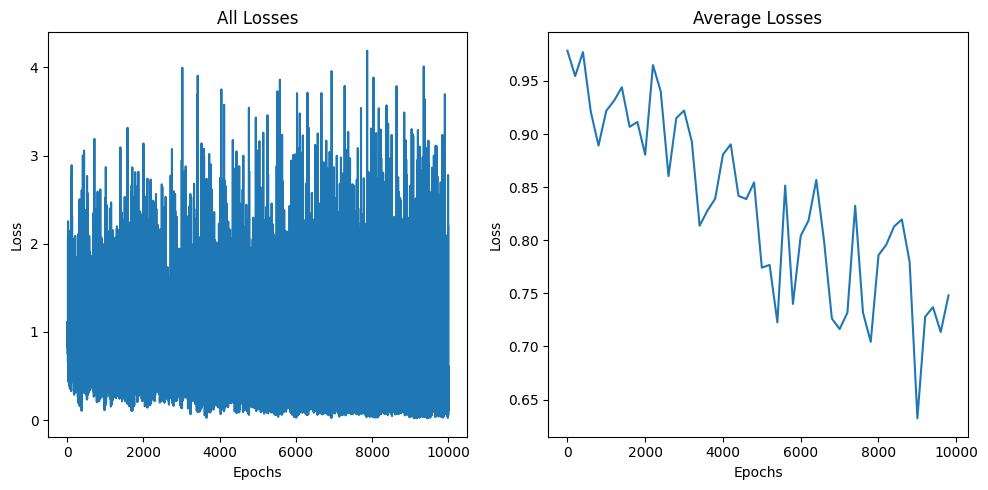

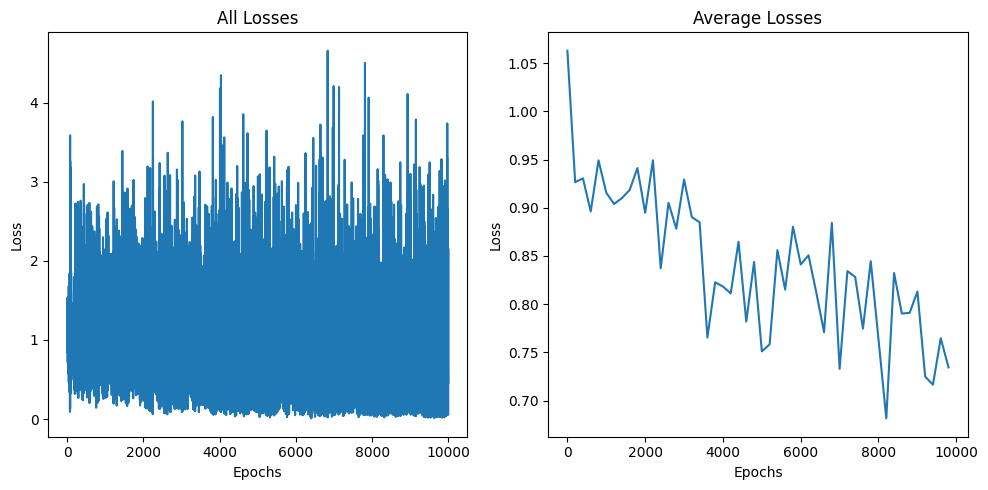

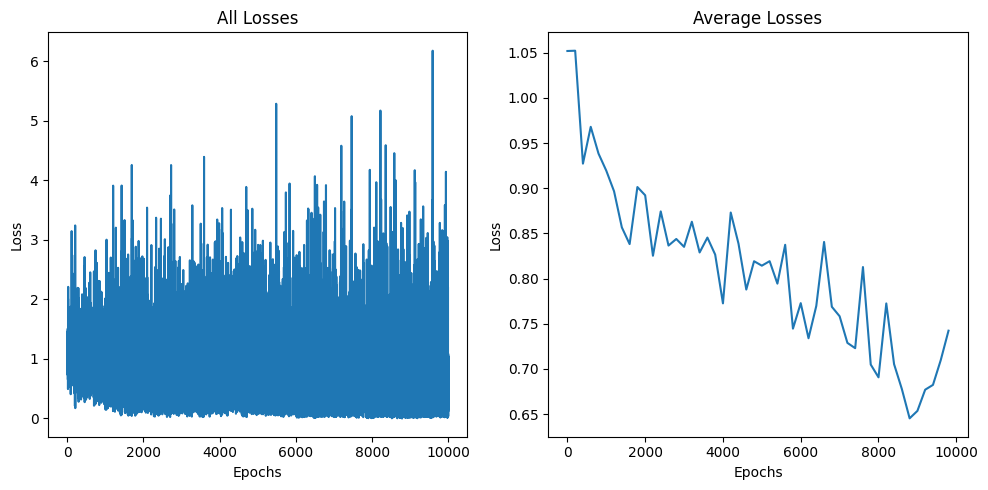

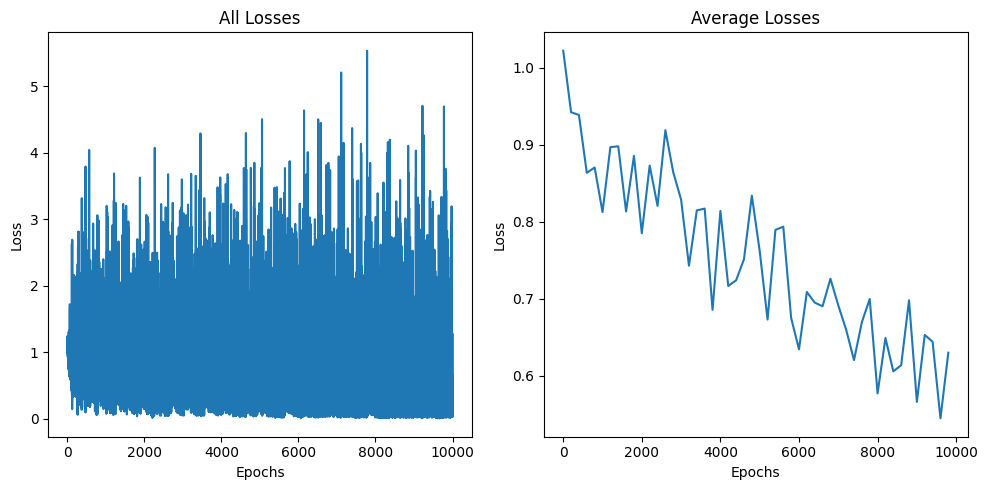

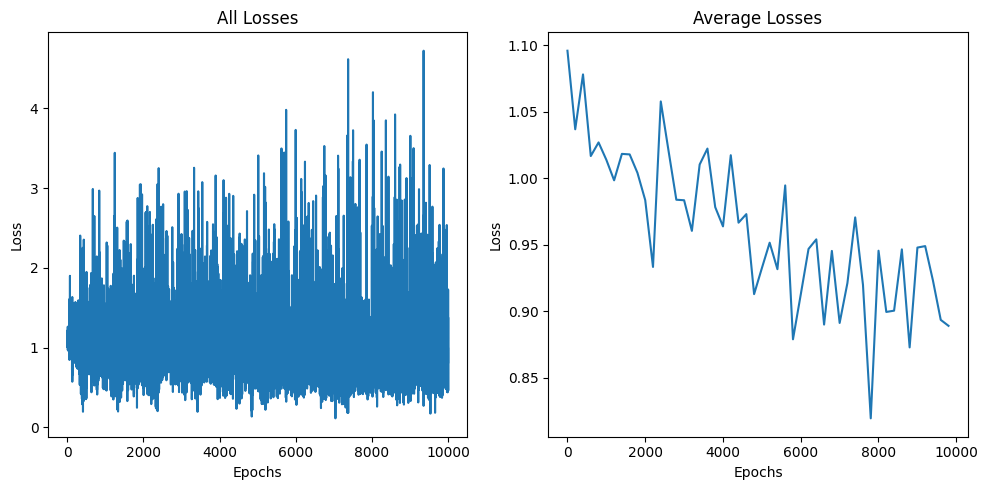

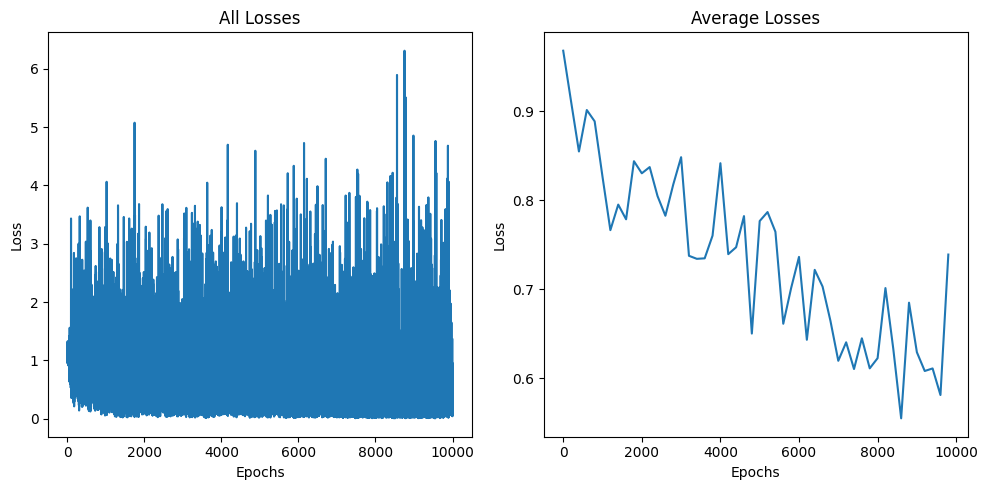

In [22]:
plot_graphs(num_epochs, plot_interval, plot_all_losses0, plot_avg_losses0)
plot_graphs(num_epochs, plot_interval, plot_all_losses1, plot_avg_losses1)
plot_graphs(num_epochs, plot_interval, plot_all_losses2, plot_avg_losses2)
plot_graphs(num_epochs, plot_interval, plot_all_losses3, plot_avg_losses3)
plot_graphs(num_epochs, plot_interval, plot_all_losses4, plot_avg_losses4)
plot_graphs(num_epochs, plot_interval, plot_all_losses5, plot_avg_losses5)

# 3. Testing and Evaluation

In [23]:
# Function to get model's prediction on test data
def predict(model, sentence, aspect, integration_type):
    with torch.no_grad():
        sent = preprocess_data([sentence])[0]
        sent_idx = [word_to_idx[word] for word in sent]
        aspect_idx = word_to_idx[aspect]
        no_sep_idx = combine_sentence_aspect(sent_idx, aspect_idx, has_sep=False)
        with_sep_idx = combine_sentence_aspect(sent_idx, aspect_idx, has_sep=True)
        aspect_tensor = torch.LongTensor([[aspect_idx]])
        
        if integration_type == NO_ASPECT:
            input_tensor = torch.LongTensor([[idx] for idx in sent_idx])
            encoder_hiddens = torch.zeros(MAX_LENGTH, model.hidden_size)
        elif integration_type == WITH_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in with_sep_idx])
            encoder_hiddens = torch.zeros(MAX_COMBINED_LENGTH+1, model.hidden_size)
        elif integration_type == ASPECT_EMBED:
            input_tensor = torch.LongTensor([[idx] for idx in sent_idx])
            encoder_hiddens = torch.zeros(MAX_LENGTH, model.hidden_size)
        elif integration_type == NO_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in no_sep_idx])
            encoder_hiddens = torch.zeros(MAX_COMBINED_LENGTH, model.hidden_size)
        elif integration_type == ASPECT_REP_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in combine_repeat_aspect(sent_idx, aspect_idx, has_sep=True)])
            encoder_hiddens = torch.zeros(MAX_REPSEP_LENGTH, model.hidden_size)
        elif integration_type == ASPECT_REP:
            input_tensor = torch.LongTensor([[idx] for idx in combine_repeat_aspect(sent_idx, aspect_idx, has_sep=False)])
            encoder_hiddens = torch.zeros(MAX_REP_LENGTH, model.hidden_size)

        input_length = input_tensor.size(0)
        encoder_hidden = model.init_hidden()
        encoder_cell = model.init_hidden()
        for ei in range(input_length):
            is_last = (ei==input_length-1)
            if is_last:
                y_output, (_, _) = model(input_tensor[ei], encoder_hidden, encoder_cell, encoder_hiddens, aspect_tensor, is_last=is_last)
            else:
                _, (encoder_hidden, encoder_cell) = model(input_tensor[ei], encoder_hidden, encoder_cell, encoder_hiddens, aspect_tensor, is_last=is_last)
                encoder_hiddens[ei] = encoder_hidden[0, 0]
            
        _, topi = y_output.topk(1)
        polarity = idx_to_polarity[topi[0].item()]
        return polarity

# Function to calculate model accuracy on test data
def evaluate(model, test_data, integration_type):
    correct = 0
    for i in range(len(test_data)):
        sentence = test_data[i]
        aspect = test_a[i]
        polarity = test_y[i]
        pred_polarity = predict(model, sentence, aspect, integration_type)
        if pred_polarity == polarity:
            correct += 1
    accuracy = correct / len(test_data)
    return accuracy

## Aspect Repeat no Separator

In [24]:
# Get the accuracy of the model on test data
integration_type = ASPECT_REP
accuracy0 = evaluate(model5, test_x, integration_type)
print(f'Accuracy: {accuracy0:.4f}')

Accuracy: 0.6559


## Aspect Repeat with Separator

In [25]:
# Get the accuracy of the model on test data
integration_type = ASPECT_REP_SEP
accuracy0 = evaluate(model0, test_x, integration_type)
print(f'Accuracy: {accuracy0:.4f}')

Accuracy: 0.6293


## Aspect Embedding

In [26]:
# Get the accuracy of the model on test data
integration_type = ASPECT_EMBED
accuracy1 = evaluate(model1, test_x, integration_type)
print(f"Accuracy: {accuracy1:.4f}")

Accuracy: 0.6404


## With Separator

In [27]:
# Get the accuracy of the model on test data
integration_type = WITH_SEP
accuracy2 = evaluate(model2, test_x, integration_type)
print(f"Accuracy: {accuracy2:.4f}")

Accuracy: 0.6548


## No Aspect

In [28]:
# Get the accuracy of the model on test data
integration_type = NO_ASPECT
accuracy3 = evaluate(model3, test_x, integration_type)
print(f"Accuracy: {accuracy3:.4f}")

Accuracy: 0.4828


## No Separator

In [29]:
# Get the accuracy of the model on test data
integration_type = NO_SEP
accuracy4 = evaluate(model4, test_x, integration_type)
print(f"Accuracy: {accuracy4:.4f}")

Accuracy: 0.6781
